# Classifying nodes on PubMed

Graph sage implements two techniques
- 

## Download the dataset

In [1]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='./data', name='Pubmed')
data = dataset[0]

print(f'Dataset: {dataset}')

Processing...


Dataset: Pubmed()


Done!


In [3]:
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print('Graph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3
Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


There are only 60 training nodes for 1,000 test nodes, which is quite challenging. (6 / 94) split 

# Neighbour Sampling

- PyG implements NeighborLoader class to perform this
- Let's keep 10 neighbours(1st hop) of our target node and 10 of their own neighbours(2nd hop)

- We can group 60 target nodes(training nodes) into batches of 16 nodes, which will result in 4 batches

In [4]:
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(data, num_neighbors=[10, 10], batch_size=16, input_nodes=data.train_mask,)

# Verifying the obtained 4 subgraphs (batches)
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[514, 500], edge_index=[2, 618], y=[514], train_mask=[514], val_mask=[514], test_mask=[514], batch_size=16)
Subgraph 1: Data(x=[296, 500], edge_index=[2, 380], y=[296], train_mask=[296], val_mask=[296], test_mask=[296], batch_size=16)
Subgraph 2: Data(x=[372, 500], edge_index=[2, 452], y=[372], train_mask=[372], val_mask=[372], test_mask=[372], batch_size=16)
Subgraph 3: Data(x=[237, 500], edge_index=[2, 293], y=[237], train_mask=[237], val_mask=[237], test_mask=[237], batch_size=12)


These subgraphs contain more than 60 nodes, which is noraml, since any neighbour can be sampled. Let's plot them!

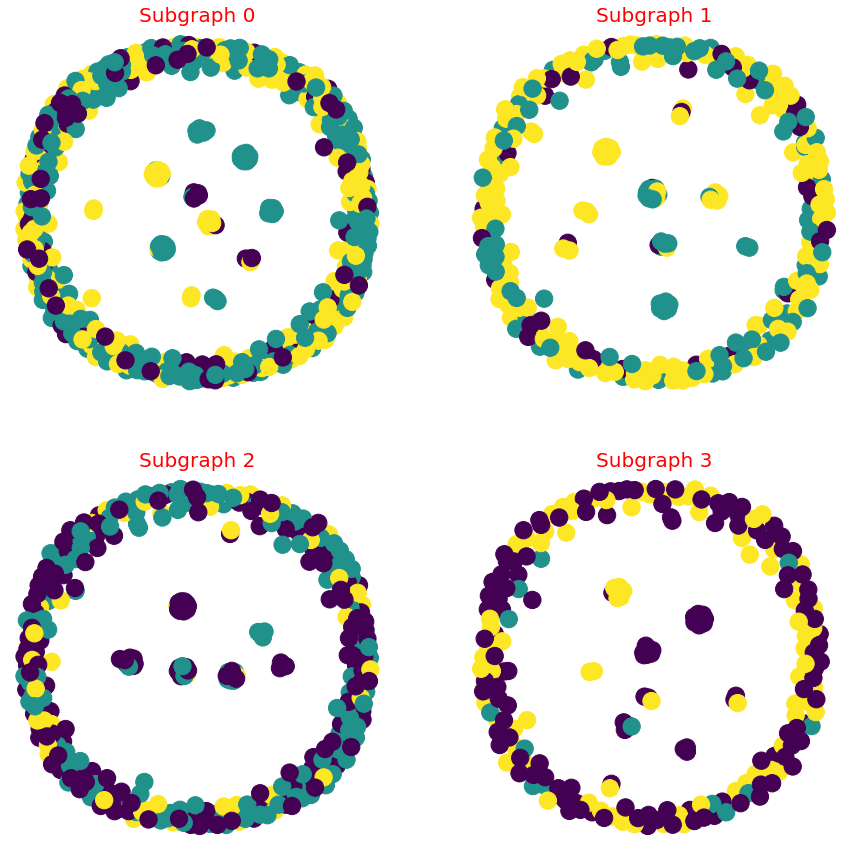

In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

fig = plt.figure(figsize=(15, 15))

for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=20, color='red')
    plt.axis('off')
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), with_labels=False, node_color=subdata.y,)
plt.show()

Most of the nodes have a degree of 1 because of the way neighbour sampling works.

In [22]:
# Accuracy of the model
def accuracy(y_pred, y):
    return ((y_pred == y).sum() / len(y)).item()

In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)
        
    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.train()
        
        for epoch in range(epochs+1):
            total_loss, val_loss, acc, val_acc = 0, 0, 0, 0
            
            for  batch in train_loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss
                
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()
                
                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
                
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader) * 100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader) * 100:.2f}%')
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [33]:
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)
graphsage.fit(data, 2000)

GraphSAGE(
  (sage1): SAGEConv(500, 64)
  (sage2): SAGEConv(64, 3)
)
Epoch   0 | Train Loss: 0.353 | Train Acc:  25.83% | Val Loss: 1.12 | Val Acc: 17.50%
Epoch  20 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 63.75%
Epoch  40 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.53 | Val Acc: 66.07%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.56 | Val Acc: 64.29%
Epoch  80 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 72.32%
Epoch 100 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.52 | Val Acc: 71.17%
Epoch 120 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.42 | Val Acc: 81.97%
Epoch 140 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.45 | Val Acc: 82.58%
Epoch 160 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.51 | Val Acc: 84.85%
Epoch 180 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.48 | Val Acc: 80.30%
Epoch 200 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.54 | V

In [34]:
# Testing the model accuracy
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc * 100:.2f}%')

GraphSAGE test accuracy: 74.20%
